# Representing images

One of the most common and important data types for computer vision are, of course,
images. The most straightforward way to represent images is probably by using the
grayscale value of each pixel in the image. Usually, grayscale values are not very indicative
of the data they describe. For example, if we saw a single pixel with grayscale value 128,
could we tell what object this pixel belonged to? Probably not. Therefore, grayscale values
are not very effective **image features**.

## Using color spaces

Alternatively, we might find that colors contain some information that raw grayscale values
cannot capture. Most often, images come in the conventional RGB color space, where every
pixel in the image gets an intensity value for its apparent redness (R), greenness (G), and
blueness (B). However, OpenCV offers a whole range of other color spaces, such as **Hue
Saturation Value (HSV)**, **Hue Saturation Lightness (HSL)**, and the **Lab color space**. Let's
have a quick look at them.


### Encoding images in RGB space

I am sure that you are already familiar with the RGB color space, which uses additive
mixing of different shades of red, green, and blue to produce different composite colors.
The RGB color space is useful in everyday life, because it covers a large part of the color
space that the human eye can see. This is why color television sets or color computer
monitors only need to care about producing mixtures of red, green, and blue light.

We can load a sample image in BGR format using `cv2.imread`:

In [1]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

In [2]:
img_bgr = cv2.imread('data/lena.jpg')#/lena.jpg')

If you have ever tried to display a BGR image using Matplotlib or similar libraries, you
might have noticed a weird blue tint to the image. This is due to the fact that Matplotlib
expects an RGB image. To achieve this, we have to permute the color channels using
`cv2.cvtColor`:

In [3]:
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)

Then we can use Matplotlib to plot the images (BGR on the left, RGB on the right):

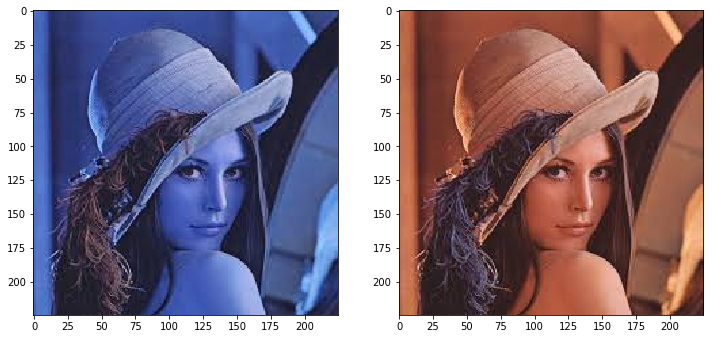

In [4]:
plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.imshow(img_bgr)
plt.subplot(122)
plt.imshow(img_rgb);

### Encoding images in HSV and HLS space

However, ever since the RGB color space was created, people have realized that it is
actually quite a poor representation of human vision. Therefore, researchers have
developed two alternative representations. One of them is called HSV, which stands for
hue, saturation, and value, and the other one is called HLS, which stands for hue,
lightness, and saturation. You might have seen these color spaces in color pickers and
common image editing software. In these color spaces, the hue of the color is captured by a
single hue channel, the colorfulness is captured by a saturation channel, and the lightness or
brightness is captured by a lightness or value channel.

In OpenCV, an RGB image can easily be converted to HSV color space using
`cv2.cvtColor`:

In [5]:
img_hsv = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2HSV)

The same is true for the HLS color space. In fact, OpenCV provides a whole range of
additional color spaces, which are available via `cv2.cvtColor`. All we need to do is to
replace the color flag with one of the following:
- HLS (hue, lightness, saturation) using `cv2.COLOR_BGR2HLS`
- LAB (lightness, green-red, and blue-yellow) using `cv2.COLOR_BGR2LAB`
- YUV (overall luminance, blue-luminance, red-luminance) using `cv2.COLOR_BGR2YUV`

## Detecting corners in images

One of the most straightforward features to find in an image are **corners**. 

OpenCV
provides at least two different algorithms to find corners in an image:
- **Harris corner detection**: Knowing that edges are areas with high-intensity changes in all directions, Harris and Stephens came up with a fast way of finding such areas. This algorithm is implemented as `cv2.cornerHarris` in OpenCV.
- **Shi-Tomasi corner detection**: Shi and Tomasi have their own idea of what are good features to track, and they usually do better than Harris corner detection by finding the N strongest corners. This algorithm is implemented as `cv2.goodFeaturesToTrack` in OpenCV.

Harris corner detection works only on grayscale images, so we first want to convert our
BGR image to grayscale:

In [6]:
img_bgr = cv2.imread('data/rubic-cube.png')

In [7]:
img_gray = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2GRAY)

We specify the pixel neighborhood size considered for corner detection (`blockSize`), an aperture parameter for the edge detection (`ksize`), and the so-called Harris detector-free parameter (`k`):

In [8]:
corners = cv2.cornerHarris(img_gray, 2, 3, 0.04)

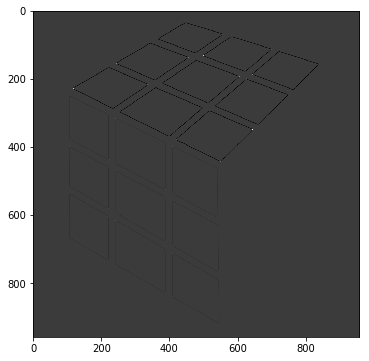

In [9]:
plt.figure(figsize=(12,6))
plt.imshow(corners, cmap='gray')

In [10]:
corners_to_plot = np.where(corners>0.1*corners.max())

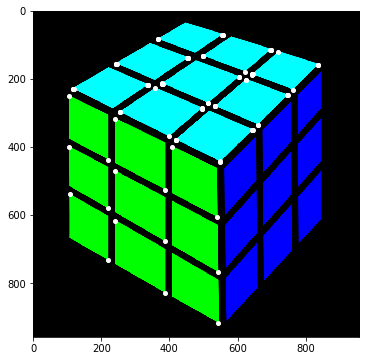

In [11]:
plt.figure(figsize=(12,6))
plt.imshow(img_bgr);
plt.plot(corners_to_plot[1],corners_to_plot[0],'o',c='w',markersize=4)

In [12]:
ret, corners = cv2.threshold(corners,0.1*corners.max(),255,0)
corners = np.uint8(corners)

In [13]:
retVal, labels, stats, centroids = cv2.connectedComponentsWithStats(corners)

In [14]:
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 100, 0.001)

In [15]:
corners = cv2.cornerSubPix(img_gray,np.float32(centroids),(5,5),(-1,-1),criteria)

In [16]:
corners = np.int0(corners)
centroids = np.int0(centroids)

In [17]:
corners_to_plot = [corners[:,0],corners[:,1]]
centroids_to_plot = [centroids[:,0],centroids[:,1]]

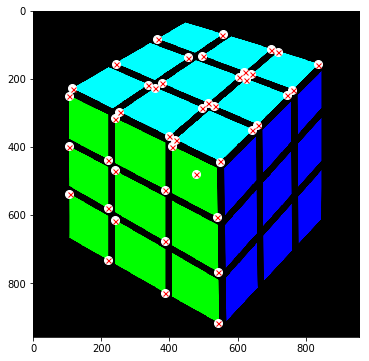

In [18]:
plt.figure(figsize=(12,6))
plt.imshow(img_bgr);
plt.plot(corners_to_plot[0],corners_to_plot[1],'o',c='w',markersize=8)
plt.plot(centroids_to_plot[0],centroids_to_plot[1],'x',c='r',markersize=5)

In [19]:
np.absolute(centroids-corners).sum(axis=0)

array([41, 31])

In [20]:
height, width, channels = img_bgr.shape

In [21]:
np.absolute(centroids-corners).sum(axis=0)/(width,height) * 100

array([4.27974948, 3.23590814])

## Using Star Detector and BRIEF Descriptor

However, corner detection is not sufficient when the scale of an image changes. Multiple papers have been published describing different algorithms for feature detection and description. We will look at a combination of **Star Feature Detector** and **Binary Robust Independent Elementary Features (BRIEF) Descriptor**. The feature detector identifies the keypoints in the image and the feature descriptor calculates the actual feature value for all the keypoints.

In [22]:
img = cv2.imread('data/rubic-cube.png')

In [23]:
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

In [24]:
star = cv2.xfeatures2d.StarDetector_create()

In [25]:
brief = cv2.xfeatures2d.BriefDescriptorExtractor_create()

In [26]:
keyPoints = star.detect(gray, None)

In [27]:
keyPoints, descriptors = brief.compute(img, keyPoints)

In [28]:
def drawKeypoint (img, keypoint, color):
    draw_shift_bits = 4
    draw_multiplier = 1 << draw_shift_bits
    
    center = (int(round(keypoint.pt[0])),int(round(keypoint.pt[1])))
    
    radius = int(round(keypoint.size/2.0))
    
    # draw the circles around keypoints with the keypoints size
    cv2.circle(img, center, radius, color, 1, cv2.LINE_AA)# draw_shift_bits)
    
    # draw orientation of the keypoint, if it is applicable
    if keypoint.angle  != -1:
        
        srcAngleRad = keypoint.angle * np.pi/180.0
        
        orient = (int(round(np.cos(srcAngleRad)*radius)), \
                 int(round(np.sin(srcAngleRad)*radius)))
        
        cv2.line(img, center, (center[0]+orient[0],\
                               center[1]+orient[1]),\
                color, 1, cv2.LINE_AA)
    else:
        # draw center with R=1
        radius = 1 * draw_multiplier
        cv2.circle(img, center, radius,\
                  color, 1, cv2.LINE_AA)
    
    return img

In [29]:
from random import randint
def drawKeypoints(image, keypoints):
    for keypoint in keypoints:
        color = (randint(0,256),randint(0,256),randint(0,256))
        image = drawKeypoint(image, keypoint, color)
    return image

In [30]:
result = drawKeypoints(img, keyPoints)

In [31]:
print("Number of keypoints = {}".format(len(keyPoints)))

Number of keypoints = 453


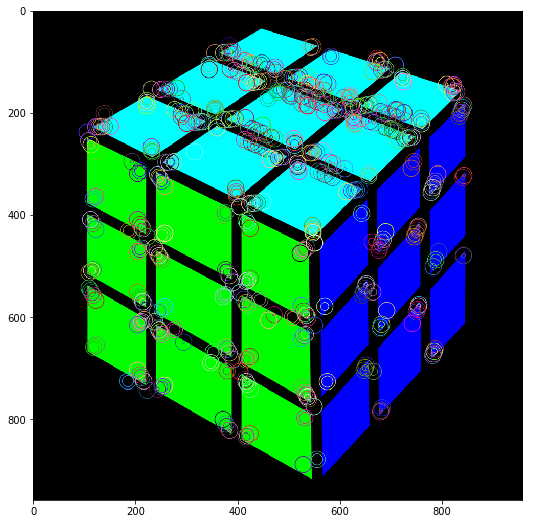

In [32]:
plt.figure(figsize=(18,9))
plt.imshow(result)

Pretty cool right? 
As easy and fast BRIEF is, it doesn't work well with rotation of an image. Let's see how ORB helps us in resolving this.

## Using Oriented FAST and Rotated BRIEF (ORB)

In [33]:
img = cv2.imread('data/rubic-cube.png')
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

In [34]:
orb = cv2.ORB_create()

In [35]:
keyPoints = orb.detect(gray,None)

In [36]:
keyPoints, descriptors = orb.compute(gray, keyPoints)

In [37]:
print("Number of keypoints = {}".format(len(keyPoints)))

Number of keypoints = 497


In [38]:
result = drawKeypoints(img,keyPoints)

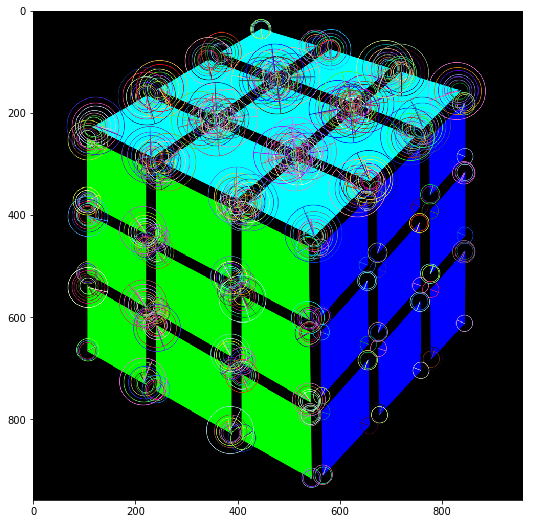

In [39]:
plt.figure(figsize=(18,9))
plt.imshow(result)

The algorithm works in two steps:

- **detect**:  This step identifies interesting points in an image (also known as keypoints)
- **compute**:  This step computes the actual feature values for every keypoint.

Keypoints can be detected with a single line of code.

In [40]:
img = cv2.imread('data/rubic-cube.png')
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

In [41]:
orb = cv2.ORB_create()

In [42]:
keyPoints2, descriptors2 = orb.detectAndCompute(gray, None)

In [43]:
print("Number of keypoints = {}".format(len(keyPoints)))

Number of keypoints = 497


In [44]:
np.allclose(descriptors,descriptors2)

True